# Tutoriel - Word2vec en utilisant Pytorch

Ce notebook explique comment implémenter la technique de NLP, appelée word2vec, à l’aide de Pytorch. Word2vec a pour objectif principal de construire un "word embedding", c’est-à-dire une représentation de mots ("latent and semantic free") dans un espace continu. Pour ce faire, cette approche exploite un réseau de neurones peu profond, avec seulement 2 couches. Ce tutoriel explique : 

* comment générer l'ensemble de données adapté à word2vec
* comment construire le réseau de neurones
* comment accélérer l'approche


## Les données

Présentons les concepts de base du NLP : 

* Corpus : le corpus est la collection de textes définissant le jeu de données
* vocabulaire: l'ensemble des mots contenu dans les données

En guise d'exemple, nous utilisons le nouveau corpus contenu dans la base de données "Brown", disponible dans la librairie nltk. 

In [156]:
# Téléchargement des différentes bibliothèques... A faire une fois
#nltk.download('universal_tagset') #Pour traduire les types de tags
#nltk.download('brown')
#nltk.download('words')
#nltk.download('stopwords')
#nltk.download('names')
#nltk.download('cmudict')

# Install a pip package in the current Jupyter kernel PENSER A UTILISER le --user pour l'installer en local !
#import sys
#!{sys.executable} -m pip install --user torchvision

import re
import nltk
from nltk.corpus import brown

corpus = []

### Lexiques et listes de mots dans nltk

Le package NLTK comprend également un certain nombre de lexiques et de listes de mots. Celles-ci sont accessibles comme des corpus de texte. Les exemples suivants illustrent l’utilisation des corpus de la liste de mots:

In [157]:
from nltk.corpus import names, stopwords, words

print(words.fileids())
print(words.words('en')[1:5]) 
print(len(words.words('en')))
print(stopwords.fileids()[1:5])
print(stopwords.words('french')[1:5])
print(names.fileids())
print(names.words('female.txt')[1:5])

['en', 'en-basic']
['a', 'aa', 'aal', 'aalii']
235886
['azerbaijani', 'danish', 'dutch', 'english']
['aux', 'avec', 'ce', 'ces']
['female.txt', 'male.txt']
['Abagail', 'Abbe', 'Abbey', 'Abbi']


Le corpus du dictionnaire de prononciation CMU contient des transcriptions de plus de 100 000 mots. Vous pouvez y accéder sous forme de liste d'entrées (chaque entrée étant composée d'un mot, d'un identifiant et d'une transcription) ou sous forme de dictionnaire de mots en listes de transcriptions. Les transcriptions sont codées sous forme de n-uplets de chaînes de phonèmes.


In [158]:
from nltk.corpus import cmudict
print(cmudict.entries()[653]) 
# charger le corpus entier cmudict dans le dictionnaire python:
transcr = cmudict.dict()
print([transcr[w][0] for w in 'Kim Antunez'.lower().split()])

('acetate', ['AE1', 'S', 'AH0', 'T', 'EY2', 'T'])
[['K', 'IH1', 'M'], ['AA0', 'N', 'T', 'UW1', 'N', 'EH0', 'Z']]


### Appropriation des données de type corpus

Commençons par nous approprier le fonctionnement du format "corpus" dans Python...


In [159]:
# Description du corpus brown
print(brown.readme())

BROWN CORPUS

A Standard Corpus of Present-Day Edited American
English, for use with Digital Computers.

by W. N. Francis and H. Kucera (1964)
Department of Linguistics, Brown University
Providence, Rhode Island, USA

Revised 1971, Revised and Amplified 1979

http://www.hit.uib.no/icame/brown/bcm.html

Distributed with the permission of the copyright holder,
redistribution permitted.



In [160]:
print("Chemin de la base de données Brown : ")
print(str(nltk.corpus.brown).replace('\\\\','/'))

print("Nombre de mots du fichier ca01 la base Brown ")
len(brown.words('ca01'))

print("\n 10 premiers noms de fichiers de la base Brown : ")
print(brown.fileids()[:10])

print("\n 100 premiers caractères du fichier ca01 la base Brown : ")
print(brown.raw('ca01')[:100])

print("\n 10 premiers mots du fichier ca01 la base Brown : ")
print(brown.words('ca01')[1:10])

#print("\n Première phrase du fichier ca01 la base Brown : ")
#print(brown.sents('ca01')[1:10])

#print("\n Premier paragraphe du fichier ca01 la base Brown : ")
#print(brown.paras('ca01'))

print("\n Mots de la base Brown en entier : ")
print(brown.words())

Chemin de la base de données Brown : 
<CategorizedTaggedCorpusReader in 'W:/AppData/nltk_data/corpora/brown'>
Nombre de mots du fichier ca01 la base Brown 

 10 premiers noms de fichiers de la base Brown : 
['ca01', 'ca02', 'ca03', 'ca04', 'ca05', 'ca06', 'ca07', 'ca08', 'ca09', 'ca10']

 100 premiers caractères du fichier ca01 la base Brown : 


	The/at Fulton/np-tl County/nn-tl Grand/jj-tl Jury/nn-tl said/vbd Friday/nr an/at investigation/nn

 10 premiers mots du fichier ca01 la base Brown : 
['Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of']

 Mots de la base Brown en entier : 
['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]


La base Brown a la particularité d'être annotée (pas seulement en texte plein). Elle est annotée avec des balises de partie de parole et définit des méthodes supplémentaires étiquetées_*(), dans lesquels les mots sont des nuplets (mot, balise), plutôt que de simples chaînes de mots. Ici les tags semblent correspondre au type des mots

In [161]:
print(brown.tagged_words())
print(brown.tagged_words(tagset='universal')) 


[('The', 'AT'), ('Fulton', 'NP-TL'), ...]
[('The', 'DET'), ('Fulton', 'NOUN'), ...]


Plusieurs corpus inclus dans NLTK contiennent des documents classés par sujet, genre, polarité, etc. Outre l’interface de corpus standard, ces corpus permettent d’accéder à la liste des catégories et à l'association entre les documents et leurs catégories (dans les deux sens). On peut accéder aux catégories à l'aide de la méthode categories(). Cette méthode a un argument facultatif qui spécifie un document ou une liste de documents, nous permettant d'associer (un ou plusieurs) documents vers (une ou plusieurs) catégories.

Outre la mise en correspondance des catégories et des documents, ces corpus permettent un accès direct à leur contenu via les catégories. Au lieu d'accéder à un sous-ensemble d'un corpus en spécifiant un ou plusieurs ID de fichier, nous pouvons identifier une ou plusieurs catégories, ici la catégorie news. Notez que qu'il le faut pas préciser à la fois les documents et catégories, sinon cela renverait une erreur.

In [162]:
print(brown.categories()[1:5]) 
print(brown.categories(['ca01','cb01']))
print(brown.tagged_words(categories='news'))

#Dans le contexte d'un système de catégorisation de texte,
#nous pouvons facilement tester si la catégorie attribuée à un document est correcte :
def classify(doc): return 'news'   #
doc = 'ca01'
print(classify(doc) in brown.categories(doc))


['belles_lettres', 'editorial', 'fiction', 'government']
['editorial', 'news']
[('The', 'AT'), ('Fulton', 'NP-TL'), ...]
True


### Préparations de nos données dans brown

Revenons au traitement de la base brown pour le NLP. 

Ici, les caractères autres que des lettres sont supprimés de la chaîne. De plus, le texte est mis en minuscule.


In [163]:
#print(brown.fileids('news')[1:5])
#print(brown.sents('ca01')[0][1:5]) #5 premiers mots de la 1e phrase
#raw_text = list(itertools.chain.from_iterable(brown.sents('ca01')))[1:5] #idem sans préciser de numéro de phrase
#print(' '.join(raw_text))

import itertools  #NEW KIM

for cat in ['news']:  #On se restreint à la catégorie "news" des articles contenus dans brown. 
    for text_id in brown.fileids(cat): #On parcourt tous les fichiers de la catégorie news
        raw_text = list(itertools.chain.from_iterable(brown.sents(text_id))) #on récupère les mots
        text = ' '.join(raw_text) #justaxposer les mots en mettant des espaces
        text = text.lower() #texte mis en minuscule. 
        text.replace('\n', ' ') #on supprime les sauts de lignes
        text = re.sub('[^a-z ]+', '', text) #on enlève les caractères non alphabétiques
        corpus.append([w for w in text.split() if w != '']) #on intègre ces mots sous forme de 
        # liste de liste dans corpus

print(corpus[0][1:10]) #Les 10 premiers mots du premier texte (ca01) de corpus

['fulton', 'county', 'grand', 'jury', 'said', 'friday', 'an', 'investigation', 'of']


### Sous-échantillonnage des mots fréquents

La première étape du prétraitement des données consiste à équilibrer les occurrences de mots dans les données. Pour ce faire, nous effectuons un sous-échantillonnage des mots fréquents. Appelons $p_i$ la proportion du mot i dans le corpus. Alors la probabilité $P(wi)$ de garder le mot dans le corpus est définie comme suit :



$$P(w_i) = \dfrac{10^{-3}}{p_i}\left(\sqrt{10^3 p_i} + 1\right)$$

<span style="background-color: #FFFF00">Formule à comprendre</span>

In [164]:
from collections import Counter
import random, math

# On fixe l'aléa pour bien pouvoir comprendre nos résultats
random.seed(1)

#Retourne un float aléatoire dans l'intervalle [0.0, 1.0).
#print(random.random())

# Fonction qui en entrée prend un corpus et renvoie un corpus filtré
def subsample_frequent_words(corpus): #création d'une fonction qui prend un corpus en entrée
    filtered_corpus = [] 
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus)))) #{'the': 159650, 'fulton': 350, ...
    sum_word_counts = sum(list(word_counts.values())) #nombre total de mots
    word_counts = {word: word_counts[word]/float(sum_word_counts) for word in word_counts} 
    # calculs de proportion dont la somme fait 100 {'the': 0.07339892418739369, 'fulton': 0.00016091214197048412,
    for text in corpus: #on parcourt tous les articles du corpus
        filtered_corpus.append([]) #on crée une sous liste à chaque nouvel article
        for word in text: #et pour tous les mots de l'article
            if random.random() < (1+math.sqrt(word_counts[word] * 1e3)) * 1e-3 / float(word_counts[word]):
                #si une proportion tirée au hasard est inférieure à la probabilité de garder ce mot
                filtered_corpus[-1].append(word) #on enlève ce mot. 
    return filtered_corpus

<span style="background-color: #FFFF00"> La condition random < P(wi) ne me semble pas intuitive</span>

In [314]:
#On applique la fonction de filtrage au corpus
corpus = subsample_frequent_words(corpus)

vocabulary = set(itertools.chain.from_iterable(corpus)) # transforme le nouveau corpus au format
#set() transforme des listes [] ou tuples () en format set {} et les classe.
#{'bernadines', 'removed', 'lining',

word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)} # on associe un index a chaque mot
#{'bernadines': 0, 'removed': 1,
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)} # on associe un mot a chaque index
#{0: 'bernadines', 1: 'removed', 

<span style="background-color: #FFFF00"> Je ne comprends pas pourquoi vocabulary est réordonné par rapport à corpus (à quoi cela sert-il) et surtout comment est déterminé l'ordre de vocabulary ?  </span>

### Construire des sacs de mots

Word2vec est une approche de "sac" de mots. Pour chaque mot de l'ensemble de données, nous devons extraire les mots de contexte (*context words*), c'est-à-dire les mots voisins dans une certaine fenêtre (*window*) de longueur fixe. Par exemple, dans la phrase suivante :

*My cat is lazy, it sleeps all day long*

Si nous considérons le mot cible (*target word*) *lazy* et que nous choisissons une fenêtre de taille 2, les mots du contexte sont *cat*, *is*, *it* et *sleeps*.

In [166]:
#Petit aparté pour comprendre la fonction enumerate de Python
l1 = ["eat","sleep","repeat"] 
s1 = "geek"
obj1 = enumerate(l1) 
obj2 = enumerate(s1)   
print("Return type:",type(obj1))
print(list(enumerate(l1))) #C'est plutôt cette fonction d'indiciation de mot qu'on utilise ci-dessous
print(list(enumerate(s1,2))) #Ici on compte le nombre de lettres dans un mot

Return type: <class 'enumerate'>
[(0, 'eat'), (1, 'sleep'), (2, 'repeat')]
[(2, 'g'), (3, 'e'), (4, 'e'), (5, 'k')]


In [167]:
import numpy as np

#print(list(enumerate(corpus[0]))[:10])
#[(0, 'fulton'), (1, 'county'),

# On fixe l'aléa pour bien pouvoir comprendre nos résultats
random.seed(1)

context_tuple_list = []
w = 4 #taille de la fenêtre = 4

# créer des pairs de mots cibles et contexte
for text in corpus: #pour tous les articles du corpus (nettoyé par la méthodes ci-dessus)
    for i, word in enumerate(text): #pour chaque association nb de mots (i) + mot (word)
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word, text[j]))
                
#print(context_tuple_list[0:10])    
#[('fulton', 'county'), ('fulton', 'grand'), ('fulton', 'jury'), ('county', 'fulton')...
print("Il y a {} paires de mots cibles et de contexte".format(len(context_tuple_list)))

Il y a 473644 paires de mots cibles et de contexte


## Construire le réseau (méthodologie)

### L’algorithme du gradient

#### Le gradient "from scratch"

L'algorithme du gradient désigne un algorithme d'optimisation différentiable. Il est par conséquent destiné à minimiser (ou maximiser si on multiplie par -1 par exemple) une fonction réelle différentiable définie sur un espace euclidien (par exemple, ${R}^{n}$, l'espace des n-uplets de nombres réels, muni d'un produit scalaire) ou, plus généralement, sur un espace hilbertien. L'algorithme est itératif et procède donc par améliorations successives. Au point courant, un déplacement est effectué dans la direction opposée au gradient, de manière à faire décroître la fonction. Le déplacement le long de cette direction est déterminé par la technique numérique connue sous le nom de recherche linéaire. Cette description montre que l'algorithme fait partie de la famille des algorithmes à directions de descente.

On se donne un point/itéré initial $x_{0} \in \mathbb {E}$ et un seuil de tolérance $\varepsilon \geqslant 0$
L'algorithme du gradient définit une suite d'itérés 
$ x_{1},x_{2},\ldots \in \mathbb {E}$ jusqu'à ce qu'un test d'arrêt soit satisfait. Il passe de $x_{k}$ à $x_{k+1}$ par les étapes suivantes. 

1. Simulation : calcul de $\nabla f(x_{k})$
2. Test d'arrêt : si $\|\nabla f(x_{k})\|\leqslant \varepsilon$, arrêt.
3. Calcul du pas $\alpha _{k}$ par une règle de recherche linéaire sur f en $x_{k}$ le long de la direction $ -\nabla f(x_{k})$
4. Nouvel itéré : $x_{k+1}=x_{k}-\alpha _{k}\nabla f(x_{k})$

*Exemple* : 

Fonction de prédiction d'une prédiction : $h(x) = \theta_0 + \theta_1 x$

Coût de l'erreur : $J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=0}^{m} (h(x_i) - y_i)^2$

Objectif : Trouver les meilleurs paramètres $\theta_0$ et $\theta_1$ revient à minimiser (trouver le minimum) la fonction du coût.

Algorithme : $\theta_{j+1} = \theta_{j} - \alpha \frac{\partial J(\theta_0, \theta_1)}{\partial \theta_{j}}$




In [168]:
from __future__ import division
# -*- coding: utf-8 -*-
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# On fixe l'aléa pour bien pouvoir comprendre nos résultats
random.seed(1)

def calculer_cost_function(theta_0, theta_1):
    global_cost  = 0
    for i in range(len(X)):
        cost_i = ((theta_0 + (theta_1 * X[i])) - Y[i]) * ((theta_0 + (theta_1 * X[i])) - Y[i]) 
        global_cost+= cost_i
    return (1/ (2 * len(X))) * global_cost

# données de régressions
df = pd.DataFrame([[6.1101, 17.592], [5.5277, 9.1302], [8.5186, 13.662]]) 

X =  df.iloc[0:len(df),0]#une seule variable prédictive car régression univariée
Y =  df.iloc[0:len(df),1]#Valeurs observées (à prédire)

#un tableau pour stocker les valeurs d'erreurs global à chaque tour d'itération
COST_RECORDER = []

# la taille de notre ensemble de données d'apprentissage
M = len(X)

learning_rate_ALPHA = float(0.0001) #0.0001
initial_theta_0 = float(0)
initial_theta_1 = float(0)
nombre_iterations = 1000


def calculer_derivees_partielles(ancien_theta_0, ancien_theta_1):
    derivee_theta_0 = float(0)
    derivee_theta_1 = float(0)
    for i in range(0, len(X)):
        derivee_theta_0 += float(((ancien_theta_0 + (ancien_theta_1 * X[i])) - float(Y[i])))
        derivee_theta_1 += (((ancien_theta_0 + (ancien_theta_1 * X[i]))) - float(Y[i])) * float(X[i])  
    derivee_theta_0 = (1/M) * derivee_theta_0
    derivee_theta_1 = (1/M) * derivee_theta_1
    return [derivee_theta_0, derivee_theta_1]

def calculer_nouvelles_theta(ancien_theta_0, ancien_theta_1):
    [derivee_theta_0, derivee_theta_1] = calculer_derivees_partielles(ancien_theta_0,ancien_theta_1)
    nouvelle_theta_0 = ancien_theta_0 - (learning_rate_ALPHA * derivee_theta_0)
    nouvelle_theta_1 = ancien_theta_1 - (learning_rate_ALPHA * derivee_theta_1)
    COST_RECORDER.append(calculer_cost_function(nouvelle_theta_0, nouvelle_theta_1))
    return [nouvelle_theta_0,nouvelle_theta_1]


def lancer_gradient_descent():
    tmp_theta_0 = initial_theta_0
    tmp_theta_1 = initial_theta_1   
    for i in range(nombre_iterations):
        [nouvelle_theta_0, nouvelle_theta_1] = calculer_nouvelles_theta(tmp_theta_0, tmp_theta_1)
        tmp_theta_0 = nouvelle_theta_0
        tmp_theta_1 = nouvelle_theta_1
    return [tmp_theta_0, tmp_theta_1]         

[final_theta_0, final_theta_1] = lancer_gradient_descent()
loss = calculer_cost_function(final_theta_0, final_theta_1)
print("Après {0} itérations theta_0 = {1}, theta_1 = {2} et la loss vaut {3}".format(nombre_iterations,
                                                                                     final_theta_0, final_theta_1,
                                                                                     COST_RECORDER[nombre_iterations-1]))



Après 1000 itérations theta_0 = 0.30481117467429525, theta_1 = 1.894204663182967 et la loss vaut 7.178563368300242


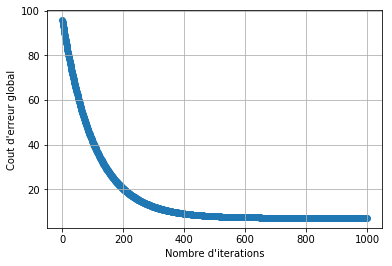

In [169]:
#print COST_RECORDER
xx = []; yy=[]

#dessiner l'avancer des differents de J(theta_0, theta_1)
for i in range(len(COST_RECORDER)):
   xx.append(i)
   yy.append(COST_RECORDER[i])

axes = plt.axes()
axes.grid()
plt.xlabel('Nombre d\'iterations')
plt.ylabel('Cout d\'erreur global')
plt.scatter(xx,yy)
plt.show()

#### L'algorithme du gradient simplifié avec Pytorch

Remarque : fortement inspiré de : http://vision.gel.ulaval.ca/~cgagne/enseignement/apprentissage/A2018/presentations/iam-sem11-pytorch.pdf

Pytorch sert initialement à manipuler des operations de tenseur et les deriver automatiquement ! 

A force de faire des operations, Pytorch construit un graphe de calcul. Ce graphe permet de suivre toutes les operations necessaires au calcul du resultat. Ainsi, il est ensuite très facile pour Pytorch de calculer automatiquement la derivée à chaque ́etape du graphe. Pour indiquer que l’on veut que pytorch calcule la derivee par rapport à un certain tenseur, on doit utiliser le paramètre `requires_grad`. 

Voici ci-dessous l'exemple d'une régression linéaire.

In [170]:
import torch

#a = torch.FloatTensor([[1,2,3], [2,3,4]],requires_grad=True)
a = Variable(torch.FloatTensor([[1,2,3], [2,3,4]]), requires_grad = True)
#a.requires_grad = True # ou définition après coup

# y est la vraie sortie et x les vrais contrôles
x = Variable(torch.FloatTensor([1.1,2.1,3.1]), requires_grad = True) #x1 x2 x3
y = Variable(torch.FloatTensor([1]), requires_grad = True) #y1

#On déclare un vecteur de poids et un biais aleatoire :
W = torch.randn(3, requires_grad=True) # tensor de 2 dimensions tiré au hasard W=w1,w2,w3
b = torch.randn(1, requires_grad=True) # 1 dimension b=b1

# On execute la chaîne d’operations (proche de numpy). y_hat est la sortie predite, x l’entree
y_hat = W.dot(x) + b  # [yh1] = w1x1 + w2x2 + w3x3 + b1
#[1,1] = [1,3][3,1] + [1,1]
print("\ny_hat : ",y_hat,"\n")

#On calcule l’erreur quadratique. Ici y est la vraie sortie
err = 0.5 * (y_hat - y) ** 2 #[e1] = 0.5 (w1x1 + w2x2 + w3x3 + b1 -y1)^2
print("err : ",err,"\n")

#Puisque y est un scalaire, on peut deriver l'equation à l’aide d’une seule methode, backward():
err.backward() 

#derr/dy = - (y_hat - y)
#print(y.grad.data)
#print(y - y_hat)

print(W.grad) 
#derr/dw1 = w1 (w1x1 + w2x2 + w3x3 + b1 -y1) = w1 (yh1 - y1)
print(x*(y_hat-y))


#On peut alors recuperer les dérivées dans les tenseurs W et b :
W_grad = W.grad
b_grad = b.grad

#Et pourquoi pas, faire un pas dans la bonne direction :
alpha = 0.001 #pas
W = W - alpha * W.grad
b = b - alpha * b.grad


y_hat :  tensor([1.6918], grad_fn=<ThAddBackward>) 

err :  tensor([0.2393], grad_fn=<MulBackward>) 

tensor([0.7610, 1.4528, 2.1445])
tensor([0.7610, 1.4528, 2.1445], grad_fn=<ThMulBackward>)


In [171]:
# Un exemple autre exemple pour être sûr de bien comprendre la fonction backward...
from torch.autograd import Variable
import torch

x = Variable(torch.FloatTensor([[2,1]]), requires_grad=True) #[b1,b2]
M = Variable(torch.FloatTensor([[1,2],[3,4]])) #[[a1,a2],[a3,a4]]
y = torch.mm(x, M) #[5., 8.] [y1, y2] = [a1b1 + a3b2 , a2b1 + a4b2]
y.backward(torch.FloatTensor([[2,1]]), retain_graph = True)
print(x.grad.data) #([[ 4., 10.]])

#car :
#dL/db1 = dL/dy1 * dy1/db1 + dL/dy2 * dy2/db1 = 2 * a1 + 1 * a2 = 4
#dL/db2 = dL/dy1 * dy1/db2 + dL/dy2 * dy2/db2 = 2 * a3 + 1 * a4 = 10


tensor([[ 4., 10.]])


#### L'utilité d'initialiser les gradients avec zero_grad

La fonction  `zero_grad` initialise les gradients de tous les paramètres du modèle à zéro. Dans PyTorch, nous devons initialiser les gradients à 0 avant de commencer à effectuer une rétropropagation du gradient (*backpropagation*)  - calculer le gradient de l'erreur pour chaque neurone d'un réseau de neurones, de la dernière couche vers la première -, car PyTorch accumule les gradients à chaque nouveau passage. Ceci est pratique quand on entraîne des réseaux de neurones récurrents (*Recurrent neural network* ou *RNN*). Ainsi, l’action par défaut consiste à accumuler (c’est-à-dire à sommer) les gradients à chaque appel de `loss.backward()`.

De ce fait, lorsque vous démarrez votre boucle d’entraînement, vous devez idéalement mettre à zéro les gradients afin de mettre à jour le paramètre correctement. Sinon, le gradient indiquerait une direction autre que la direction souhaitée vers le minimum (ou le maximum, dans le cas d'objectifs de maximisation).

Appeler x.grad.data.zero_() avant y.backward() peut s’assurer que x.grad est exactement le même que le y'(x) courant, et non une somme de tous les y'(x) des itérations précédentes.

Voici un exemple pour comprendre : 

In [172]:
import torch
from torch.autograd import Variable

x = Variable(torch.Tensor([[3.14]]), requires_grad=True)

print("SANS ZERO")

for t in range(2):
    y = 2 *x.sin() 
    y.backward()
    print(x.grad.data) ##dy/dx

x = Variable(torch.Tensor([[0]]), requires_grad=True) 

print("AVEC ZERO")

for t in range(2):
    if x.grad is not None:
        x.grad.data.zero_()
    y = x.sin() 
    y.backward()
    print(x.grad)
  

SANS ZERO
tensor([[-2.0000]])
tensor([[-4.0000]])
AVEC ZERO
tensor([[1.]])
tensor([[1.]])


### Les réseaux de neurones

#### Définir un réseau 

Définir un réseau avec des tenseurs directement serait une Tâche ardue. `Pytorch` nous offre une manière de déclarer facilement des réseaux ! Typiquement on utilise le package `torch.nn` et on hérite de `nn.Module`.

La classe `torch.nn.Module` est la classe de base pour tous les modules de réseaux neuronaux. C'est pourquoi le modèle word2vec va ici être une sous-classe de celle-ci. Mais les modules peuvent également contenir d'autres modules, ce qui permet de les imbriquer dans une arborescence (*tree structure*). 

Un module reçoit en entrée des *tensors* et renvoie d'autres *tensors* en sortie, mais il peut également conserver un état interne tel que les tensors contenant des paramètres pouvant être appris (*learnable*). Le package nn définit également un ensemble de fonctions de *loss* utiles couramment utilisées lors de la formation de réseaux de neurones, comme la `CrossEntropyLoss()` que l'on utilise dans word2vec.

`Pytorch` offre plusieurs couches toutes descendantes de  `torch.nn.Module`. Le but est de composer des modules pour créer des modules plus complexes. Voici quelques modules de base. Les autres sont consultables ici : https://pytorch.org/docs/stable/nn.html. 

* Linéaire `torch.nn.Linear(in_features, out_features, bias=True)`
* Convolution 2d `torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,padding=0, dilation=1, groups=1, bias=True)`


Remarque : la plupart des couches sont également disponibles sous la forme de fonctions à partir de `torch.nn.functional`. Mais ATTENTION, le module n’est pas au courant que ces couches existent lorsqu’elles sont déclarées en fonctiond directement. Les paramètres de ces couches ne sont pas pris en compte dans la liste des paramètres. Certaines couches comme le dropout ou la batchnorm ont des comportements différents en entraînement et en test. Changer le mode du réseau change le comportement d’une couche classe, mais pas d’une couche fonction. Pour toutes ces raisons, il vaut mieux utiliser les couches fonctions seulement lorsque la couche n’a pas de paramètres à optimiser et/ou lorsque le comportement ne varie pas entre l’entraînement et le test.

Exemple : réseau Lenet-5 
![](http://cedric.cnam.fr/vertigo/Cours/ml2/_images/LeNet5.png)


In [173]:
import torch.nn as nn
import torch.nn.functional as F

class Lenet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.C1 = nn.Conv2d(1, 6, kernel_size=5) #Convolution C1
        self.S2 = nn.MaxPool2d(2) #Subsampling S2
        self.C3 = nn.Conv2d(6, 16, kernel_size=5) #Convolution C3
        self.S4 = nn.MaxPool2d(2) #Subsampling S4
        self.C5 = nn.Linear(16*5*5, 120) #Full connexion C5
        self.F6 = nn.Linear(120, 64) #Full connexion F6
        self.output = nn.Linear(64, 10) # Gaussian output

    def forward(self, x):
        y = self.S2(F.relu(self.C1(x))) #C1 -> S2 = fonction relu
        y = self.S4(F.relu(self.C3(y))) #C3 -> S4 = fonction relu
        y = y.view(-1, 16*5*5) # redimensionne
        y = F.relu(self.C5(y)) 
        y = F.relu(self.F6(y))
        return self.output(y) 


In [174]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
     super(Model, self).__init__()
     self.conv1 = nn.Conv2d(1, 20, 5)
     self.conv2 = nn.Conv2d(20, 20, 5)

def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))


#### Entraîner un réseau 

Une fois que l’on a chargé les données, pour entraîner un réseau, il faut :
* un optimisateur qui se trouve dans `torch.optim`.
* Une fonction d’erreur qui se trouve dans `torch.nn`, comme les couches.
Exemple : classification MNIST, optimisateur = `torch.optim.SGD` et erreur = `torch.nn.CrossEntropyLoss`
Exemple : web2vec (ici),  optimisateur = X et erreur = `torch.nn.CrossEntropyLoss`

Il est aussi possible avec Pytorch d’utiliser un modèle pré-entraîné (voir lien pour plus de détails)

<span style="background-color: #FFFF00"> Exemple ci-dessous ne fonctionne pas (installation de torchvision ne semble pas aboutir sur serveur ENSAE. A eclaircir et tester plus tard) </span>


In [175]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST ## Ne marche pas
from torchvision.transforms import ToTensor ## Ne marche pas

nb_epoch = 10
batch_size = 64
learning_rate = 0.01
momentum = 0.9 
# télécharge dans ’path/to/data’ 
train_set = MNIST(train=True, transform=ToTensor(),download=True)
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
model = Lenet5()
model.train() # mettre en mode entraînement
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=momentum)
criterion = torch.nn.CrossEntropyLoss() 

for i_epoch in range(nb_epoch):
	for i_batch, batch in enumerate(train_loader):
		X, y = batch
        optimizer.zero_grad() # important! remet les gradients à 0
		y_hat = model(X) # calcule la prediction
		loss = criterion(y_hat, y) # calcule l’erreur 
		loss.backward() # dérive le graphe
		optimizer.step() # effectue une ́etape d’optimisation 


TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-175-219607009874>, line 20)

## Construire le réseau (application) 

Il existe deux approches pour word2vec : 

* CBOW (*Continuous Bag Of Words* ou sac continu de mots). Il prédit le mot cible conditionnellement au contexte. En d'autres termes, les mots de contexte sont l'entrée et le mot cible est la sortie.

* Skip-gram. Il prédit le contexte conditionnellement au mot cible. En d'autres termes, le mot cible est l'entrée et les mots de contexte sont la sortie.

Le code suivant concerne la méthode CBOW.

Le vocabulaire est représenté sous la forme d'un codage *one-hot encoding*, ce qui signifie que la variable d'entrée est un vecteur de la taille du vocabulaire (de taille n si n mots). Pour un mot, ce vecteur vaut 0 partout sauf à l'endroit de l'indice du mot dans le vocabulaire (i pour le ième mot et $x_i$ = 1).

Le codage *one-hot* est projeté (*mapped*)  sur un vecteur-mot (*embedding*) , c'est-à-dire une représentation latente du mot en tant que vecteur contenant des valeurs continues et dont la taille est plus petit que le vecteur de codage *one-hot*.

Pour chaque mot de contexte, une fonction softmax prend l'*embedding du mot*, produisant une distribution de probabilité du mot cible sur le vocabulaire.

<img src="https://rguigoures.github.io/images/cbow.png" width="50%">

### Le réseau CBOW

In [316]:
import torch
# import torch.nntorch.nn  as  nn
import torch.nn  as  nn #KIM
#import torch.autogradtorch.aut  as autograd
import torch.autograd  as  autograd #KIM
import torch.optim as optim
import torch.nn.functional as F

# Définition du réseau de Neurone appelé Word2Vec
class Word2Vec(nn.Module):

    #Définition des deux couches
    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        #Couche Embedding :méthode nn.Embedding
        self.linear = nn.Linear(embedding_size, vocab_size) #Couche de sortie : méthode nn.Linear
        
    def forward(self, context_word):
        emb = self.embeddings(context_word) 
        hidden = self.linear(emb)
        #out = F.log_softmax(hidden) #depreciated
        out = F.log_softmax(hidden, dim=1) #puis on utilise la fonction softmax
        # KIM For matrices, it’s 1. For others, it’s 0.
        return out


<span style="background-color: #FFFF00">A creuser les codes et méthodos de :  </span>

* <span style="background-color: #FFFF00">méthode nn.Embedding</span>
* <span style="background-color: #FFFF00">méthode nn.Linear</span>
* <span style="background-color: #FFFF00">méthode nn.CrossEntropyLoss</span>
* <span style="background-color: #FFFF00">méthode optim.Adam</span>


### Le réseau Skip-GRAM

<span style="background-color: #FFFF00">TODO
 </span>

### Arrêter l'algorithme avant la fin

Avant de commencer l’apprentissage, introduisons le concept d’arrêt précoce (*early stopping*). Il vise à arrêter l'apprentissage lorsque la perte (*loss*) ne diminue pas de manière significative (paramètre  `min_percent_gain`) après un certain nombre d'itérations (paramètre  `patience`). Un arrêt précoce est généralement utilisé sur la perte de validation (*validation loss*), mais dans le cas de word2vec, il n’y a pas de validation car l’approche n’est pas supervisée. Nous appliquons plutôt l'arrêt précoce sur les données d'entraînement à la place (*training loss*).

<span style="background-color: #FFFF00">mieux comprendre le concept de validation et d'apprentissage supervisé</span>


In [177]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience #patience = 5 => Nombre de loss qui peuvent être accumulées dans list-loss
        self.loss_list = [] #On initialise la liste des loss
        self.min_percent_gain = min_percent_gain / 100. #min_percent_gain = 0.1
        
    def update_loss(self, loss): #fonction d'actualisation de la loss
        self.loss_list.append(loss) #On ajoute la nouvelle loss calculée dans loss-list
        if len(self.loss_list) > self.patience: #Si la liste de loss dépasse patience
            del self.loss_list[0] #... on supprime le 1er élément de list-loss
    
    def stop_training(self): #fonction d'arrêt de l'algorithme, vaut true si on doit l'arrêter
        if len(self.loss_list) == 1: #si list-loss ne contient qu'un élément
            return False #on continue l'algorithme
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list) #on calcule le gain 
        print("Loss gain: {}%".format(round(100*gain,2))) #on imprime le gain
        if gain < self.min_percent_gain: #si le gain est faible
            return True #on arrête l'algo 
        else: #sinon
            return False #on le continue

### Apprentissage

Pour l'apprentissage (*learning*), nous utilisons l'entropie croisée (*cross entropy*) comme fonction de loss. Le réseau de neurones est entraîné avec les paramètres suivants:

* taille d'intégration : 200 (*embedding size*)
* taille du lot : 2000A (*batch size*)

In [178]:
## Etape 1 : On transforme les couple target context en couple de tensor (autre format)

context_tensor_list = []

for target, context in context_tuple_list[0:10]: #[('fulton', 'county'), ('fulton', 'grand')
#for target, context in context_tuple_list: # MODIFIE CAR SINON TROP LONG A TOURNER
    target_tensor = autograd.Variable(torch.LongTensor([word_to_index[target]])) #fulton devient tensor([6582])
    context_tensor = autograd.Variable(torch.LongTensor([word_to_index[context]]))  #county devient tensor([8950])
    context_tensor_list.append((target_tensor, context_tensor)) 
    #(tensor([6582]), tensor([8950])) ajouté à context_tensor_list

In [179]:
vocabulary_size = len(vocabulary) #12132
net = Word2Vec(embedding_size=3, vocab_size=vocabulary_size) # On crée un réseau "net" de classe word2vec
loss_function = nn.CrossEntropyLoss() #fonction de loss : crossEntropy
optimizer = optim.Adam(net.parameters()) #optimizer : Adam
#early_stopping = EarlyStopping()
early_stopping = EarlyStopping(patience=5, min_percent_gain=5)

## Etape 2 : 
while True:
    losses = [] #initialisation du vecteur de loss
    for target_tensor, context_tensor in context_tensor_list:    
        net.zero_grad() #initialisation importante des gradients comme évoqué avant
        log_probs = net(context_tensor) # On applique word2vec au premier couple target context ??
        #cela donne un vecteur de taille [1, taille_voc=12132] : tensor([ -9.0275,  -8.8258,  -9.0572, 
        loss = loss_function(log_probs, target_tensor) #on calcul la loss de ce vecteur : tensor(9.6383, grad_fn=<NllLossBackward>)   
        loss.backward() #on dérive le graphe
        optimizer.step() #on effectue une étape d'optimisation (descente de gradient ?)
        losses.append(loss.data) # on rajoute 9,63 dans losses à la fin il y a autant éléments dans losses que de couples context tensor (10)
    print("Mean Loss: ", np.mean(losses)) # j'indique la loss moyenne
    early_stopping.update_loss(np.mean(losses)) #je regarde si je dois stopper l'algorithme
    if early_stopping.stop_training(): #si oui je m'arrête là sinon je recommence
        break
        

Mean Loss:  9.617459
Mean Loss:  9.564626
Loss gain: 0.55%


<span style="background-color: #FFFF00">quel est le x dans dLoss/dx quand on fait loss.backward ? Relire théorie</span>

<span style="background-color: #FFFF00">Je ne comprends pas la syntaxe net(context_tensor) : pourquoi seul le contexte tensor est en entrée de word2vec ?</span>


## Accélérer l'approche

L'implémentation vue jusqu'à présent est assez lente. Mais bonne nouvelle, il existe des solutions pour accélérer le calcul.

### Apprentissage par lots (*batch learning*)

Afin d'accélérer l'apprentissage, nous proposons d'utiliser des lots (*batches*). Cela implique que de nombreuses observations sont transmises via le réseau avant d'effectuer la rétropropagation. En plus d’être plus rapide, c’est aussi un bon moyen de régulariser les paramètres du modèle.

In [223]:
import random

# Fonction qui crée des batches, c'est à dire des sous échantillons de context_tuple_list
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list) #réordonner au hasard le couples target, context
    batches = [] #créer une liste de batches vide
    batch_target, batch_context, batch_negative = [], [], [] #créer ces autres listes vides
    for i in range(len(context_tuple_list)): #On parcourt tous les couples target context. 
        batch_target.append(word_to_index[context_tuple_list[i][0]]) #on récupère l'id du target
        batch_context.append(word_to_index[context_tuple_list[i][1]]) #on récupère l'id du contexte
        #batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]]) ## ???????
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i]]) 
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1: #si i est le dernier élément
            tensor_target = autograd.Variable(torch.from_numpy(np.array(batch_target)).long())
            tensor_context = autograd.Variable(torch.from_numpy(np.array(batch_context)).long())
            tensor_negative = autograd.Variable(torch.from_numpy(np.array(batch_negative)).long())
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [225]:
batches_test = get_batches(context_tuple_list,5) #dimension : 94729 batches de  3 élément
#1er : liste de 5 targets, 2e liste de 5 contextes, 3e : 5 couples targets context
print(batches_test[0])

(tensor([ 7171, 11014,  1207,  6883,  7922]), tensor([10134,  9238,  5061,  5061,  7165]), tensor([[ 7171, 10134],
        [11014,  9238],
        [ 1207,  5061],
        [ 6883,  5061],
        [ 7922,  7165]]))





<span style="background-color: #FFFF00">Comment context_tuple_list[i][2] (3e élément) peut exister alors que je pensais que context_tuple_list[i] est de taille 2 ? Revoir l'algo une fois avoir compris ça... 
</span>





### Echantillonnage négatif (*negative sampling*)

L'algorithme word2vec par défaut n'exploite que les exemples positifs et la fonction de sortie est un softmax. Cependant, l'utilisation de softmax ralentit l'apprentissage: softmax est normalisé pour tout le vocabulaire, puis tous les poids du réseau sont mis à jour à chaque itération. C'est pourquoi nous décidons d'utiliser une fonction sigmoïde en sortie : seuls les poids impliquant le mot cible sont mis à jour. Mais alors, le réseau n’apprend plus d’exemples négatifs. C’est pourquoi nous devons saisir des exemples négatifs générés artificiellement.

Une fois que nous avons construit les données pour les exemples positifs, c'est-à-dire les mots situés au voisinage du mot cible, nous devons créer un ensemble de données avec des exemples négatifs. Pour chaque mot du corpus, la probabilité d'échantillonnage d'un mot de contexte négatif est définie comme suit :



$$P(w_i) = \dfrac{\mid w_i \mid^{\frac{3}{4}}}{\displaystyle\sum_{j=1}^n\mid w_j \mid^{\frac{3}{4}}}$$

Rappel : La **loi binomiale** B(n,p) concerne le nombre de succès dans n épreuves de Bernoulli indépendantes donnant chacune un résultat binaire, comme dans le jeu de pile ou face. La loi multinomiale est une généralisation de celle-ci, applicable par exemple à n jets d'un dé à six faces. La loi multinomiale est la généralisation multidimensionnelle de la loi binomiale.

M(8,p=c(p1,p2)) = [nombre de succès dans 8 épreuve de Bernoulli de proba p1, idem avec p2]

       

In [284]:
from numpy.random import multinomial

#Retourne un sous-échantillon du corpus de taille sample_size
def sample_negative(sample_size):
    
    # Création du vecteur des P(wi)
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus)))) #{'fulton': 14, 'county': 61,
    # compte de mots
    normalizing_factor = sum([v**0.75 for v in word_counts.values()]) # termes du dénominateur : 34487
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing_factor # array des P(wi) pour chaque mot i du corpus
        # {'fulton': 0.00020986448277143268, 'county': 0.0006329075767507745,
    
    #sous-échantillon du corpus
    words = np.array(list(word_counts.keys())) #['fulton' 'county' ... 'fuller']
    while True:
        word_list = [] #création d'une liste de mots
        # list(sample_probability.values()) = [0.00020986448277143268, 0.0006329075767507745, 
        #de taille 12 132 c'est à dire la taille du vocabulaire
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        # vecteur de 12132 variables de Bernoulli appartenant à [0;sample_size=8]
        for index, count in enumerate(sampled_index): #on indicie le vecteur sampled_index (1, 0), (2, 0), (3, 0)
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list #comme un return sauf que retourne un générateur à la place d'un vecteur
        #return(word_list)

In [295]:
## modifié car sinon trop long à tourner...

import numpy as np
context_tuple_list = []
w = 4
#negative_samples = sample_negative(8)
negative_samples = sample_negative(3)

for text in corpus[1:2]: #pour tous les articles du corpus [['austin', 'texas', 'committee',
#for text in corpus:
    for i, word in enumerate(text): #pour chaque indice de mot et mot de l'article
        first_context_word_index = max(0,i-w) #premier indice de mot contexte associé au target word
        last_context_word_index = min(i+w, len(text)) #dernier indice de mot context
        for j in range(first_context_word_index, last_context_word_index): 
            #pour tous les indices de mots contextes associé (y compris le mot target du coup)
            if i!=j: #si on exclut le mot target de ces mots contextes
                context_tuple_list.append((word, text[j], next(negative_samples))) 
                #j'ajoute à context_tuple_list, le mot de l'article, son contexte,
                #et l'échantillon de mot du negative sample
print("There are {} pairs of target and context words".format(len(context_tuple_list)))


There are 10771 pairs of target and context words


context_tuple_list est de cette forme si sample_negative(3) : 

    context_tuple_list[0] : ('austin', 'texas', ['absent', 'going', 'recovering'])
    context_tuple_list[1] : ('austin', 'committee', ['concluded', 'loading', 'drawn'])

### Echantillonnage des paires (*pair sampling*)

<span style="background-color: #FFFF00">TODO</span> 


### Le réseau

La principale différence avec le réseau présenté ci-dessus réside dans le fait que nous n’avons plus besoin d’une distribution de probabilité sur les mots en sortie. Nous pouvons plutôt avoir une probabilité pour chaque mot. Pour obtenir cela, nous pouvons remplacer la sortie softmax out par une sigmoïde, prenant des valeurs comprises entre 0 et 1.

L'autre principale différence est que la perte doit être calculée sur la sortie des observations uniquement, car nous fournissons la sortie attendue ainsi qu'un ensemble d'exemples négatifs. Pour ce faire, nous pouvons utiliser un logarithme négatif de la sortie en tant que fonction de perte.

Pour un mot target $w_T$, un mot de contexte $w_C$ et un exemple négatif $w_N$, les mots-vecteurs (*embeddings*) respectifs sont définis comme étant $e_T$, $e_C$ et $e_N$. La fonction de perte (*loss*) l est définie comme suit :

$$l = -log(\sigma(e_T^T e_C)) - \displaystyle\sum_i log(\sigma(- e_T^T e_{N,i}))$$

In [298]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F


class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.embeddings_target(target_word)
        emb_context = self.embeddings_context(context_word)
        emb_product = torch.mul(emb_target, emb_context)
        emb_product = torch.sum(emb_product, dim=1)
        out = torch.sum(F.logsigmoid(emb_product))
        emb_negative = self.embeddings_context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2))
        emb_product = torch.sum(emb_product, dim=1)
        out += torch.sum(F.logsigmoid(-emb_product))
        return -out

Le réseau de neurones est entraîné avec les paramètres suivants:

* taille d'intégration : 200 (*embedding size*)
* taille du lot : 2000 (*batch size*)

In [301]:
## modifié car sinon trop long à tourner...

import time

vocabulary_size = len(vocabulary)

loss_function = nn.CrossEntropyLoss()
#net = Word2Vec(embedding_size=200, vocab_size=vocabulary_size)
net = Word2Vec(embedding_size=10, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

while True:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", np.mean(losses))
    early_stopping.update_loss(np.mean(losses))
    if early_stopping.stop_training():
        break

TypeError: unhashable type: 'list'

<span style="background-color: #FFFF00">à débugger ci-dessus...</span> 

Une fois le réseau entraîné, nous pouvons utiliser le mot-vecteur (*word embedding*) et calculer la similarité entre les mots. La fonction suivante calcule les n premiers mots les plus proches pour un mot donné. La similitude utilisée est le cosinus.

In [302]:
import numpy as np

def get_closest_word(word, topn=5):
    word_distance = []
    emb = net.embeddings_target
    pdist = nn.PairwiseDistance()
    i = word_to_index[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long)
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocabulary)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long)
            v_j = emb(lookup_tensor_j)
            word_distance.append((index_to_word[j], float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]

In [319]:
get_closest_word("love")

[('knox', 1.4831182956695557),
 ('integration', 1.9943172931671143),
 ('severely', 2.1332778930664062),
 ('easier', 2.3286726474761963),
 ('officers', 2.3364176750183105)]